# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import math

# sklearn for utilization
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import recall_score, precision_score, fbeta_score
from sklearn.model_selection import StratifiedKFold

# modelling for ensemble method
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

# visualization purpose
import matplotlib.pyplot as plt

# utils
import pickle
import random
import warnings
warnings.filterwarnings("ignore")

# import our ensemble stacking model here
from models.model_ensembles import EnsembleStacking

# import our genetic algorithm model here
from models.genetic_algorithm_rouellete import GeneticAlgorithm

In [2]:
# for reproducecibility
random_state = 60251014
random.seed(random_state)

# Load Data After Preprocessing
***
Load data Breast Cancer Diagnosis and Breast Cancer Prognosis after cleaned and preprocessed

In [3]:
breast_cancer_preprocessed = pickle.load(open('../dataset/preprocessed_breast_cancer_data.pkl', 'rb'))

# diagnosis breast cancer dataset
diagnosis_X_train_original = breast_cancer_preprocessed['diagnosis']['original']['X_train']
diagnosis_X_train_downsampling = breast_cancer_preprocessed['diagnosis']['downsampling']['X_train']
diagnosis_X_train_upsampling = breast_cancer_preprocessed['diagnosis']['upsampling']['X_train']

diagnosis_y_train_original = breast_cancer_preprocessed['diagnosis']['original']['y_train']
diagnosis_y_train_downsampling = breast_cancer_preprocessed['diagnosis']['downsampling']['y_train']
diagnosis_y_train_upsampling = breast_cancer_preprocessed['diagnosis']['upsampling']['y_train']

diagnosis_X_test_original = breast_cancer_preprocessed['diagnosis']['original']['X_test']
diagnosis_y_test_original = breast_cancer_preprocessed['diagnosis']['original']['y_test']

# Defining Global Variables

In [4]:
kfold = StratifiedKFold(n_splits=5, random_state=45, shuffle=True)

# Genetic Algorithm global variables
number_of_chromosome = 45
maximum_generations = 30
crossover_rate = 0.85
mutation_rate = 0.01
convergence = 5

# Defining Global Functions

In [5]:
def create_new_input_features(ensemble_classifiers, X, y):
    all_predicted_results = dict()
    list_of_majority_voting_each_models = list()
    list_of_models = list()

    for model_name, models in ensemble_classifiers.items():
        # voting scenario for new data input prepration for ANN model
        if len(models)!=0:
            all_predicted_results[model_name] = dict()
            for sub_model_name, dict_models in models.items():
                all_predicted_results[model_name][sub_model_name] = dict_models['train'].predict(X)

            # make dataframe for 5 model prediction results on X and get the mode label for that 5 prediction
            model_df_voting = pd.DataFrame(all_predicted_results[model_name]).mode(axis=1)[0]
            list_of_models.append('majority_vote_from_'+model_name)
            list_of_majority_voting_each_models.append(model_df_voting)
            
    new_input_features = pd.concat(list_of_majority_voting_each_models, axis=1)
    new_input_features.columns = list_of_models
    new_input_features['ground_truth'] = y.copy()
            
    return new_input_features

In [6]:
def print_model_experiment_results(name_of_scenario, y_test, y_pred):
    print('\t\t' + '='*30)
    print('\t\tHASIl UJI COBA {}'.format(name_of_scenario.upper()))
    print('\t\t' + '='*30)
    print("\tAkurasi Score: ", accuracy_score(y_test, y_pred))
    print("\tMacro Recall Score: ", recall_score(y_test, y_pred, average='macro'))
    print("\tMacro Precision Score: ", precision_score(y_test, y_pred, average='macro'))
    print("\tMacro F1-score Score: ", fbeta_score(y_test, y_pred, beta=1, average='macro'))
    print("\tMacro F2-score Score: ", fbeta_score(y_test, y_pred, beta=2, average='macro'))
    print("\tMacro F0.5-score Score: ", fbeta_score(y_test, y_pred, beta=0.5, average='macro'))
    
    print()
    print()
    print(classification_report(y_test, y_pred))
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    plt.figure(figsize=(14,8))
    disp.plot()
    plt.show()

# Modelling Ensemble Classifiers for Diagnosis Breast Cancer using Genetic Optimization

## Without Data Sampling Method (Original)

### GA Optimization using Data without sampling

ITERASI KE 0 | BEST FITNESS = 0.8783843059527991
ITERASI KE 1 | BEST FITNESS = 0.8914328679311556
ITERASI KE 2 | BEST FITNESS = 0.8928217568200445
ITERASI KE 3 | BEST FITNESS = 0.9069032565607908
ITERASI KE 4 | BEST FITNESS = 0.9065512778697711
ITERASI KE 5 | BEST FITNESS = 0.8962376854500143
ITERASI KE 6 | BEST FITNESS = 0.9065512778697711
ITERASI KE 7 | BEST FITNESS = 0.896589664141034
ITERASI KE 8 | BEST FITNESS = 0.8962376854500143
ITERASI KE 9 | BEST FITNESS = 0.896589664141034
ITERASI KE 10 | BEST FITNESS = 0.8962376854500143
ITERASI KE 11 | BEST FITNESS = 0.8962376854500143
ITERASI KE 12 | BEST FITNESS = 0.8962376854500143
ITERASI KE 13 | BEST FITNESS = 0.8962376854500143
ITERASI KE 14 | BEST FITNESS = 0.896589664141034
ITERASI KE 15 | BEST FITNESS = 0.896589664141034
ITERASI KE 16 | BEST FITNESS = 0.896589664141034
ITERASI KE 17 | BEST FITNESS = 0.8962376854500143
ITERASI KE 18 | BEST FITNESS = 0.8962376854500143
ITERASI KE 19 | BEST FITNESS = 0.896589664141034
ITERASI KE 20 | 

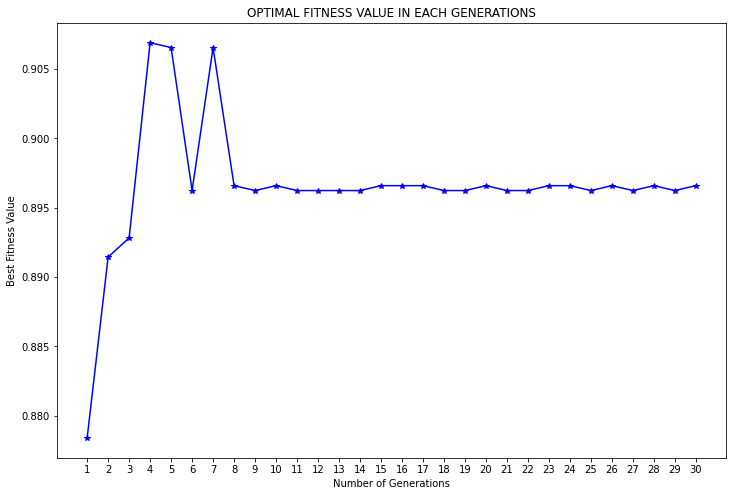

[[[1.2, 'rbf', 'scale', 0.01],
  ['gini', 'best', 1, 6, 2],
  ['l1', 'liblinear', 40, 0.0001],
  [(50, 50), 'logistic', 'adam', 0.001, 64, 'constant', 0.002]],
 0.896589664141034]

In [7]:
ga_model_original = GeneticAlgorithm(
    X_train=diagnosis_X_train_original,
    y_train=diagnosis_y_train_original,
    kfold=kfold,
    number_of_chromosome=number_of_chromosome,
    maximum_generations=maximum_generations,
    crossover_rate=crossover_rate,
    mutation_rate=mutation_rate,
    convergence=convergence
)
last_populations_original = ga_model_original.train()

# plot best fitness value in each generation
ga_model_original.plot_best_fitness_values()

# get the last generation for best solutions
best_hyperparams_genetic_algorithm_solution = last_populations_original[0]
best_hyperparams_svm = best_hyperparams_genetic_algorithm_solution[0][0]
best_hyperparams_dt = best_hyperparams_genetic_algorithm_solution[0][1]
best_hyperparams_logreg = best_hyperparams_genetic_algorithm_solution[0][2]
best_hyperparams_ann = best_hyperparams_genetic_algorithm_solution[0][3]

best_hyperparams_genetic_algorithm_solution

### Create Stacking ML Ensemble using 5-fold cross-validation

In [8]:
# create ensembles stacking method using GA hyperparameter optimized
genetic_algorithm_ensemble_classifiers_diagnosis_original = EnsembleStacking(
    diagnosis_X_train_original,
    diagnosis_y_train_original,
    diagnosis_X_test_original,
    diagnosis_y_test_original,
    kfold,
    svm_params={
        'C': best_hyperparams_svm[0],
        'kernel': best_hyperparams_svm[1],
        'gamma': best_hyperparams_svm[2],
        'tol': best_hyperparams_svm[3],
    },
    dt_params={
        'criterion': best_hyperparams_dt[0],
        'splitter': best_hyperparams_dt[1],
        'max_depth': best_hyperparams_dt[2],
        'min_samples_split': best_hyperparams_dt[3],
        'min_samples_leaf': best_hyperparams_dt[4],
    },
    logreg_params={
        'penalty': best_hyperparams_logreg[0],
        'solver': best_hyperparams_logreg[1],
        'max_iter': best_hyperparams_logreg[2],
        'tol': best_hyperparams_logreg[3],
    }
).train_ensemble()

In [9]:
# create dataframe for easy understanding from ensemble classifiers stacking results
genetic_algorithm_ensemble_classifiers_results_diagnosis_original = list()
for model in genetic_algorithm_ensemble_classifiers_diagnosis_original.keys():
    genetic_algorithm_ensemble_classifiers_results_diagnosis_original.append(
        pd.DataFrame(genetic_algorithm_ensemble_classifiers_diagnosis_original[model]).transpose().sort_values(by=['testing'], ascending=False))

# concat all dataframe results
genetic_algorithm_ensemble_classifiers_results_diagnosis_original = pd.concat(genetic_algorithm_ensemble_classifiers_results_diagnosis_original, axis=0)
genetic_algorithm_ensemble_classifiers_results_diagnosis_original

,train,training,validation,testing
model-5,"SVC(C=1.2, tol=0.01)",0.950549,0.978022,0.964912
model-1,"SVC(C=1.2, tol=0.01)",0.964286,0.901099,0.95614
model-2,"SVC(C=1.2, tol=0.01)",0.950549,0.934066,0.95614
model-3,"SVC(C=1.2, tol=0.01)",0.947802,0.956044,0.95614
model-4,"SVC(C=1.2, tol=0.01)",0.958791,0.945055,0.95614
model-4,"LogisticRegression(max_iter=40, penalty='l1', ...",0.953297,0.934066,0.964912
model-5,"LogisticRegression(max_iter=40, penalty='l1', ...",0.942308,0.967033,0.964912
model-2,"LogisticRegression(max_iter=40, penalty='l1', ...",0.947802,0.923077,0.95614
model-3,"LogisticRegression(max_iter=40, penalty='l1', ...",0.936813,0.967033,0.95614
model-1,"LogisticRegression(max_iter=40, penalty='l1', ...",0.947802,0.89011,0.947368


### Create New Input Training from stacking ensemble ML

In [10]:
genetic_algorithm_new_input_training_features_diagnosis_original = create_new_input_features(
    genetic_algorithm_ensemble_classifiers_diagnosis_original, 
    diagnosis_X_train_original,
    diagnosis_y_train_original
)

In [11]:
genetic_algorithm_new_input_training_features_diagnosis_original.head()

,majority_vote_from_svm,majority_vote_from_logreg,majority_vote_from_naive_bayes,majority_vote_from_decision_tree,ground_truth
0,0,0,0,0,0
1,1,1,0,1,1
2,0,0,0,0,0
3,0,0,0,0,0
4,0,0,0,0,0


### Feed New Input Features into ANN Model

In [12]:
# split X and y from new_input_features before feeding to ANN
new_X_train = genetic_algorithm_new_input_training_features_diagnosis_original.drop([
                                                                                    'ground_truth'], axis=1)
new_y_train = genetic_algorithm_new_input_training_features_diagnosis_original[
    'ground_truth']

# feed new X and new y into ANN
genetic_algorithm_ann_model_diagnosis_original = MLPClassifier(
    hidden_layer_sizes=best_hyperparams_ann[0],
    activation=best_hyperparams_ann[1],
    solver=best_hyperparams_ann[2],
    alpha=best_hyperparams_ann[3],
    batch_size=best_hyperparams_ann[4],
    learning_rate=best_hyperparams_ann[5],
    learning_rate_init=best_hyperparams_ann[6],
)
genetic_algorithm_ann_model_diagnosis_original.fit(new_X_train, new_y_train)
predicted_ann_train_diagnosis_original = genetic_algorithm_ann_model_diagnosis_original.predict(
    new_X_train)

print("Final Accuracy Score [Mls Ensembles + ANN] on Training Diagnostic Dataset (Original) = ",
      accuracy_score(new_y_train, predicted_ann_train_diagnosis_original))

Final Accuracy Score [Mls Ensembles + ANN] on Training Diagnostic Dataset (Original) =  0.9494505494505494


## With Data Sampling Method (Upsampling)

### GA Optimization using Data with Upsampling

ITERASI KE 0 | BEST FITNESS = 0.9174420688007643
ITERASI KE 1 | BEST FITNESS = 0.9106037983755375
ITERASI KE 2 | BEST FITNESS = 0.9098244147157191
ITERASI KE 3 | BEST FITNESS = 0.909836359292881
ITERASI KE 4 | BEST FITNESS = 0.9158265647396082
ITERASI KE 5 | BEST FITNESS = 0.806996536072623
ITERASI KE 6 | BEST FITNESS = 0.803992474916388
ITERASI KE 7 | BEST FITNESS = 0.8094332298136646
ITERASI KE 8 | BEST FITNESS = 0.7931408265647397
ITERASI KE 9 | BEST FITNESS = 0.7936663879598662
ITERASI KE 10 | BEST FITNESS = 0.8067247969421882
ITERASI KE 11 | BEST FITNESS = 0.7926003344481607
ITERASI KE 12 | BEST FITNESS = 0.7923315814620163
ITERASI KE 13 | BEST FITNESS = 0.8089016961299571
ITERASI KE 14 | BEST FITNESS = 0.8026278069756332
ITERASI KE 15 | BEST FITNESS = 0.8067247969421882
ITERASI KE 16 | BEST FITNESS = 0.8059095795508839
ITERASI KE 17 | BEST FITNESS = 0.8048106784519828
ITERASI KE 18 | BEST FITNESS = 0.8113503344481605
ITERASI KE 19 | BEST FITNESS = 0.8047897754419495
ITERASI KE 20

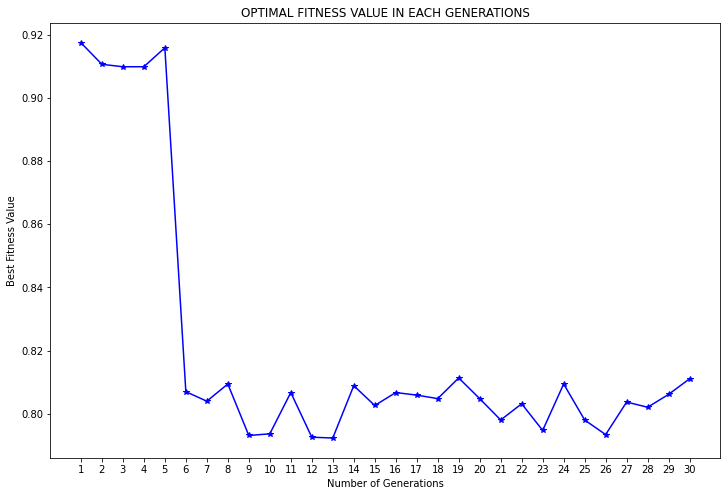

[[[1.2, 'sigmoid', 'scale', 0.0001],
  ['log_loss', 'random', 4, 6, 1],
  ['none', 'lbfgs', 20, 0.001],
  [100, 'identity', 'lbfgs', 0.001, 128, 'constant', 0.003]],
 0.8110845676063068]

In [13]:
ga_model_upsampling = GeneticAlgorithm(
    X_train=diagnosis_X_train_upsampling,
    y_train=diagnosis_y_train_upsampling,
    kfold=kfold,
    number_of_chromosome=number_of_chromosome,
    maximum_generations=maximum_generations,
    crossover_rate=crossover_rate,
    mutation_rate=mutation_rate,
    convergence=convergence
)
last_populations_upsampling = ga_model_upsampling.train()

# plot best fitness value in each generation
ga_model_upsampling.plot_best_fitness_values()

# get the last generation for best solutions
best_hyperparams_genetic_algorithm_solution = last_populations_upsampling[0]
best_hyperparams_svm = best_hyperparams_genetic_algorithm_solution[0][0]
best_hyperparams_dt = best_hyperparams_genetic_algorithm_solution[0][1]
best_hyperparams_logreg = best_hyperparams_genetic_algorithm_solution[0][2]
best_hyperparams_ann = best_hyperparams_genetic_algorithm_solution[0][3]

best_hyperparams_genetic_algorithm_solution

### Create Stacking ML Ensemble using 5-fold cross-validation

In [14]:
# create ensembles stacking method using GA hyperparameter optimized
genetic_algorithm_ensemble_classifiers_diagnosis_upsampling = EnsembleStacking(
    diagnosis_X_train_upsampling,
    diagnosis_y_train_upsampling,
    diagnosis_X_test_original,
    diagnosis_y_test_original,
    kfold,
    svm_params={
        'C': best_hyperparams_svm[0],
        'kernel': best_hyperparams_svm[1],
        'gamma': best_hyperparams_svm[2],
        'tol': best_hyperparams_svm[3],
    },
    dt_params={
        'criterion': best_hyperparams_dt[0],
        'splitter': best_hyperparams_dt[1],
        'max_depth': best_hyperparams_dt[2],
        'min_samples_split': best_hyperparams_dt[3],
        'min_samples_leaf': best_hyperparams_dt[4],
    },
    logreg_params={
        'penalty': best_hyperparams_logreg[0],
        'solver': best_hyperparams_logreg[1],
        'max_iter': best_hyperparams_logreg[2],
        'tol': best_hyperparams_logreg[3],
    }
).train_ensemble()

In [15]:
# create dataframe for easy understanding from ensemble classifiers stacking results
genetic_algorithm_ensemble_classifiers_results_diagnosis_upsampling = list()
for model in genetic_algorithm_ensemble_classifiers_diagnosis_upsampling.keys():
    genetic_algorithm_ensemble_classifiers_results_diagnosis_upsampling.append(pd.DataFrame(genetic_algorithm_ensemble_classifiers_diagnosis_upsampling[model]).transpose().sort_values(by=['testing'], ascending=False))

# concat all dataframe results
genetic_algorithm_ensemble_classifiers_results_diagnosis_upsampling = pd.concat(genetic_algorithm_ensemble_classifiers_results_diagnosis_upsampling, axis=0)
genetic_algorithm_ensemble_classifiers_results_diagnosis_upsampling

,train,training,validation,testing
model-2,"SVC(C=1.2, kernel='sigmoid', tol=0.0001)",0.083151,0.06087,0.078947
model-1,"SVC(C=1.2, kernel='sigmoid', tol=0.0001)",0.085339,0.086957,0.070175
model-3,"SVC(C=1.2, kernel='sigmoid', tol=0.0001)",0.082969,0.061404,0.070175
model-4,"SVC(C=1.2, kernel='sigmoid', tol=0.0001)",0.080786,0.078947,0.070175
model-5,"SVC(C=1.2, kernel='sigmoid', tol=0.0001)",0.074236,0.122807,0.070175
model-5,"LogisticRegression(max_iter=20, penalty='none'...",0.951965,0.938596,0.982456
model-1,"LogisticRegression(max_iter=20, penalty='none'...",0.960613,0.921739,0.973684
model-2,"LogisticRegression(max_iter=20, penalty='none'...",0.956236,0.965217,0.973684
model-4,"LogisticRegression(max_iter=20, penalty='none'...",0.954148,0.964912,0.973684
model-3,"LogisticRegression(max_iter=20, penalty='none'...",0.949782,0.973684,0.964912


### Create New Input Training from stacking ensemble ML

In [16]:
genetic_algorithm_new_input_training_features_diagnosis_upsampling = create_new_input_features(
    genetic_algorithm_ensemble_classifiers_diagnosis_upsampling, 
    diagnosis_X_train_upsampling,
    diagnosis_y_train_upsampling
)

In [17]:
genetic_algorithm_new_input_training_features_diagnosis_upsampling.head()

,majority_vote_from_svm,majority_vote_from_logreg,majority_vote_from_naive_bayes,majority_vote_from_decision_tree,ground_truth
0,0,1,1,1,1
1,1,0,0,0,0
2,0,1,1,1,1
3,1,0,0,0,0
4,0,1,1,1,1


### Feed New Input Features into ANN Model

In [18]:
# split X and y from new_input_features before feeding to ANN
new_X_train = genetic_algorithm_new_input_training_features_diagnosis_upsampling.drop([
                                                                                    'ground_truth'], axis=1)
new_y_train = genetic_algorithm_new_input_training_features_diagnosis_upsampling[
    'ground_truth']

# feed new X and new y into ANN
genetic_algorithm_ann_model_diagnosis_upsampling = MLPClassifier(
    hidden_layer_sizes=best_hyperparams_ann[0],
    activation=best_hyperparams_ann[1],
    solver=best_hyperparams_ann[2],
    alpha=best_hyperparams_ann[3],
    batch_size=best_hyperparams_ann[4],
    learning_rate=best_hyperparams_ann[5],
    learning_rate_init=best_hyperparams_ann[6],
)
genetic_algorithm_ann_model_diagnosis_upsampling.fit(new_X_train, new_y_train)
predicted_ann_train_diagnosis_upsampling = genetic_algorithm_ann_model_diagnosis_upsampling.predict(
    new_X_train)

print("Final Accuracy Score [Mls Ensembles + ANN] on Training Diagnostic Dataset (Upsampling) = ",
      accuracy_score(new_y_train, predicted_ann_train_diagnosis_upsampling))

Final Accuracy Score [Mls Ensembles + ANN] on Training Diagnostic Dataset (Upsampling) =  0.9667832167832168


## With Data Sampling Method (Downsampling)

### GA Optimization using data with Downsampling

ITERASI KE 0 | BEST FITNESS = 0.8994008714596948
ITERASI KE 1 | BEST FITNESS = 0.9003267973856209
ITERASI KE 2 | BEST FITNESS = 0.8970860566448802
ITERASI KE 3 | BEST FITNESS = 0.9132352941176471
ITERASI KE 4 | BEST FITNESS = 0.8970860566448802
ITERASI KE 5 | BEST FITNESS = 0.9086056644880175
ITERASI KE 6 | BEST FITNESS = 0.89760348583878
ITERASI KE 7 | BEST FITNESS = 0.8970860566448802
ITERASI KE 8 | BEST FITNESS = 0.8975490196078432
ITERASI KE 9 | BEST FITNESS = 0.8966230936819171
ITERASI KE 10 | BEST FITNESS = 0.8966230936819171
ITERASI KE 11 | BEST FITNESS = 0.8975490196078432
ITERASI KE 12 | BEST FITNESS = 0.8966230936819171
ITERASI KE 13 | BEST FITNESS = 0.8975490196078432
ITERASI KE 14 | BEST FITNESS = 0.8970860566448802
ITERASI KE 15 | BEST FITNESS = 0.8975490196078432
ITERASI KE 16 | BEST FITNESS = 0.898011982570806
ITERASI KE 17 | BEST FITNESS = 0.8975490196078432
ITERASI KE 18 | BEST FITNESS = 0.8966230936819171
ITERASI KE 19 | BEST FITNESS = 0.8975490196078432
ITERASI KE 20

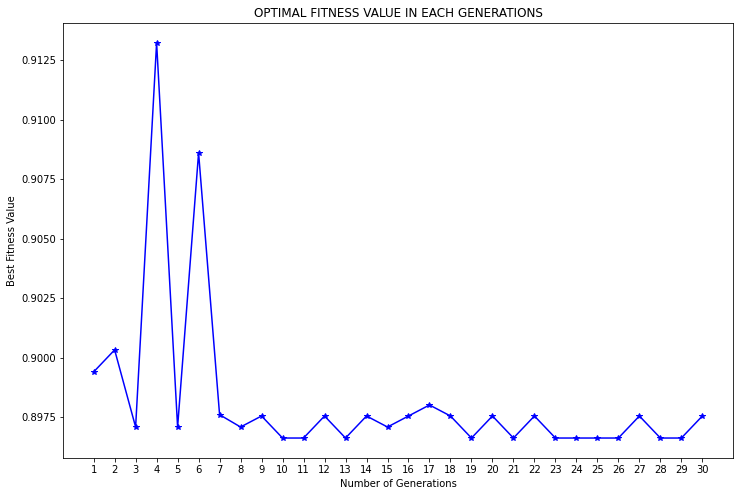

[[[1.3, 'linear', 'auto', 0.0001],
  ['log_loss', 'best', 1, 3, 3],
  ['l1', 'liblinear', 30, 1e-05],
  [100, 'relu', 'adam', 1e-05, 64, 'constant', 0.001]],
 0.8975490196078432]

In [19]:
ga_model_downsampling = GeneticAlgorithm(
    X_train=diagnosis_X_train_downsampling,
    y_train=diagnosis_y_train_downsampling,
    kfold=kfold,
    number_of_chromosome=number_of_chromosome,
    maximum_generations=maximum_generations,
    crossover_rate=crossover_rate,
    mutation_rate=mutation_rate,
    convergence=convergence
)
last_populations_downsampling = ga_model_downsampling.train()

# plot best fitness value in each generation
ga_model_downsampling.plot_best_fitness_values()

# get the last generation for best solutions
best_hyperparams_genetic_algorithm_solution = last_populations_downsampling[0]
best_hyperparams_svm = best_hyperparams_genetic_algorithm_solution[0][0]
best_hyperparams_dt = best_hyperparams_genetic_algorithm_solution[0][1]
best_hyperparams_logreg = best_hyperparams_genetic_algorithm_solution[0][2]
best_hyperparams_ann = best_hyperparams_genetic_algorithm_solution[0][3]

best_hyperparams_genetic_algorithm_solution

### Create Stacking ML Ensemble using 5-fold cross-validation

In [20]:
# create ensembles stacking method using GA hyperparameter optimized
genetic_algorithm_ensemble_classifiers_diagnosis_downsampling = EnsembleStacking(
    diagnosis_X_train_downsampling,
    diagnosis_y_train_downsampling,
    diagnosis_X_test_original,
    diagnosis_y_test_original,
    kfold,
    svm_params={
        'C': best_hyperparams_svm[0],
        'kernel': best_hyperparams_svm[1],
        'gamma': best_hyperparams_svm[2],
        'tol': best_hyperparams_svm[3],
    },
    dt_params={
        'criterion': best_hyperparams_dt[0],
        'splitter': best_hyperparams_dt[1],
        'max_depth': best_hyperparams_dt[2],
        'min_samples_split': best_hyperparams_dt[3],
        'min_samples_leaf': best_hyperparams_dt[4],
    },
    logreg_params={
        'penalty': best_hyperparams_logreg[0],
        'solver': best_hyperparams_logreg[1],
        'max_iter': best_hyperparams_logreg[2],
        'tol': best_hyperparams_logreg[3],
    }
).train_ensemble()

In [21]:
# create dataframe for easy understanding from ensemble classifiers stacking results
genetic_algorithm_ensemble_classifiers_results_diagnosis_downsampling = list()
for model in genetic_algorithm_ensemble_classifiers_diagnosis_downsampling.keys():
    genetic_algorithm_ensemble_classifiers_results_diagnosis_downsampling.append(pd.DataFrame(genetic_algorithm_ensemble_classifiers_diagnosis_downsampling[model]).transpose().sort_values(by=['testing'], ascending=False))

# concat all dataframe results
genetic_algorithm_ensemble_classifiers_results_diagnosis_downsampling = pd.concat(genetic_algorithm_ensemble_classifiers_results_diagnosis_downsampling, axis=0)
genetic_algorithm_ensemble_classifiers_results_diagnosis_downsampling

,train,training,validation,testing
model-1,"SVC(C=1.3, gamma='auto', kernel='linear', tol=...",0.918519,0.926471,0.973684
model-2,"SVC(C=1.3, gamma='auto', kernel='linear', tol=...",0.933333,0.897059,0.973684
model-3,"SVC(C=1.3, gamma='auto', kernel='linear', tol=...",0.92963,0.926471,0.973684
model-4,"SVC(C=1.3, gamma='auto', kernel='linear', tol=...",0.933579,0.895522,0.973684
model-5,"SVC(C=1.3, gamma='auto', kernel='linear', tol=...",0.933579,0.910448,0.973684
model-1,"LogisticRegression(max_iter=30, penalty='l1', ...",0.944444,0.941176,0.973684
model-3,"LogisticRegression(max_iter=30, penalty='l1', ...",0.925926,0.955882,0.973684
model-5,"LogisticRegression(max_iter=30, penalty='l1', ...",0.940959,0.910448,0.973684
model-2,"LogisticRegression(max_iter=30, penalty='l1', ...",0.940741,0.941176,0.95614
model-4,"LogisticRegression(max_iter=30, penalty='l1', ...",0.944649,0.925373,0.95614


### Create New Input Training from stacking ensemble ML

In [22]:
genetic_algorithm_new_input_training_features_diagnosis_downsampling = create_new_input_features(
    genetic_algorithm_ensemble_classifiers_diagnosis_downsampling, 
    diagnosis_X_train_downsampling,
    diagnosis_y_train_downsampling
)

In [23]:
genetic_algorithm_new_input_training_features_diagnosis_downsampling.head()

,majority_vote_from_svm,majority_vote_from_logreg,majority_vote_from_naive_bayes,majority_vote_from_decision_tree,ground_truth
0,0,0,0,0,0
1,1,1,0,1,1
2,1,1,1,1,1
3,1,1,1,1,1
4,1,1,1,1,1


### Feed New Input Features into ANN Model

In [25]:
# split X and y from new_input_features before feeding to ANN
new_X_train = genetic_algorithm_new_input_training_features_diagnosis_downsampling.drop([
                                                                                    'ground_truth'], axis=1)
new_y_train = genetic_algorithm_new_input_training_features_diagnosis_downsampling[
    'ground_truth']

# feed new X and new y into ANN
genetic_algorithm_ann_model_diagnosis_downsampling = MLPClassifier(
    hidden_layer_sizes=best_hyperparams_ann[0],
    activation=best_hyperparams_ann[1],
    solver=best_hyperparams_ann[2],
    alpha=best_hyperparams_ann[3],
    batch_size=best_hyperparams_ann[4],
    learning_rate=best_hyperparams_ann[5],
    learning_rate_init=best_hyperparams_ann[6],
)
genetic_algorithm_ann_model_diagnosis_downsampling.fit(new_X_train, new_y_train)
predicted_ann_train_diagnosis_downsampling = genetic_algorithm_ann_model_diagnosis_downsampling.predict(
    new_X_train)

print("Final Accuracy Score [Mls Ensembles + ANN] on Training Diagnostic Dataset (Downsampling) = ",
      accuracy_score(new_y_train, predicted_ann_train_diagnosis_downsampling))

Final Accuracy Score [Mls Ensembles + ANN] on Training Diagnostic Dataset (Downsampling) =  0.9467455621301775


# Modelling Ensemble Classifiers for Diagnosis Breast Cancer Dataset (Default Hyperparameters)

## Without Data Sampling Method (Original)

### Create Stacking ML Ensemble using 5-fold cross-validation

In [26]:
ensemble_classifiers_diagnosis_original = EnsembleStacking(
    diagnosis_X_train_original, 
    diagnosis_y_train_original, 
    diagnosis_X_test_original, 
    diagnosis_y_test_original, 
    kfold).train_ensemble()

In [27]:
# create dataframe for easy understanding from ensemble classifiers stacking results
ensemble_classifiers_results_diagnosis_original = list()
for model in ensemble_classifiers_diagnosis_original.keys():
    ensemble_classifiers_results_diagnosis_original.append(pd.DataFrame(ensemble_classifiers_diagnosis_original[model]).transpose().sort_values(by=['testing'], ascending=False))

# concat all dataframe results
ensemble_classifiers_results_diagnosis_original = pd.concat(ensemble_classifiers_results_diagnosis_original, axis=0)
ensemble_classifiers_results_diagnosis_original

,train,training,validation,testing
model-5,SVC(),0.950549,0.978022,0.964912
model-1,SVC(),0.964286,0.901099,0.95614
model-2,SVC(),0.947802,0.912088,0.95614
model-3,SVC(),0.947802,0.956044,0.95614
model-4,SVC(),0.958791,0.945055,0.95614
model-1,LogisticRegression(),0.945055,0.912088,0.95614
model-2,LogisticRegression(),0.945055,0.912088,0.95614
model-3,LogisticRegression(),0.934066,0.945055,0.95614
model-4,LogisticRegression(),0.942308,0.934066,0.95614
model-5,LogisticRegression(),0.928571,0.978022,0.95614


### Create New Input Training from stacking ensemble ML

In [28]:
new_input_training_features_diagnosis_original = create_new_input_features(
    ensemble_classifiers_diagnosis_original, 
    diagnosis_X_train_original,
    diagnosis_y_train_original
)

In [29]:
new_input_training_features_diagnosis_original.head()

,majority_vote_from_svm,majority_vote_from_logreg,majority_vote_from_naive_bayes,majority_vote_from_decision_tree,ground_truth
0,0,0,0,0,0
1,1,1,0,1,1
2,0,0,0,0,0
3,0,0,0,0,0
4,0,0,0,0,0


### Feed New Input Features into ANN Model

In [30]:
# split X and y from new_input_features before feeding to ANN
new_X_train = new_input_training_features_diagnosis_original.drop(['ground_truth'],axis=1)
new_y_train = new_input_training_features_diagnosis_original['ground_truth']

# feed new X and new y into ANN
ann_model_diagnosis_original = MLPClassifier()
ann_model_diagnosis_original.fit(new_X_train, new_y_train)
predicted_ann_train_diagnosis_original = ann_model_diagnosis_original.predict(new_X_train)
predicted_ann_train_diagnosis_original = ann_model_diagnosis_original.predict(new_X_train)


print()
print()
print("Final Accuracy Score [Mls Ensembles + ANN] on Training Diagnostic Dataset (Original) = ", accuracy_score(new_y_train, predicted_ann_train_diagnosis_original))



Final Accuracy Score [Mls Ensembles + ANN] on Training Diagnostic Dataset (Original) =  1.0


## With Data Sampling Method (Upsampling)

### Create Stacking ML Ensemble using 5-fold cross-validation

In [31]:
ensemble_classifiers_diagnosis_upsampling = EnsembleStacking(
    diagnosis_X_train_upsampling, 
    diagnosis_y_train_upsampling, 
    diagnosis_X_test_original, 
    diagnosis_y_test_original, 
    kfold).train_ensemble()

In [32]:
# create dataframe for easy understanding from ensemble classifiers stacking results
ensemble_classifiers_results_diagnosis_upsampling = list()
for model in ensemble_classifiers_diagnosis_upsampling.keys():
    ensemble_classifiers_results_diagnosis_upsampling.append(pd.DataFrame(ensemble_classifiers_diagnosis_upsampling[model]).transpose().sort_values(by=['testing'], ascending=False))

# concat all dataframe results
ensemble_classifiers_results_diagnosis_upsampling = pd.concat(ensemble_classifiers_results_diagnosis_upsampling, axis=0)
ensemble_classifiers_results_diagnosis_upsampling

,train,training,validation,testing
model-1,SVC(),0.958425,0.930435,0.973684
model-3,SVC(),0.943231,0.938596,0.964912
model-5,SVC(),0.958515,0.912281,0.964912
model-2,SVC(),0.95186,0.965217,0.95614
model-4,SVC(),0.949782,0.964912,0.947368
model-1,LogisticRegression(),0.932166,0.947826,0.964912
model-2,LogisticRegression(),0.934354,0.930435,0.95614
model-3,LogisticRegression(),0.936681,0.929825,0.95614
model-4,LogisticRegression(),0.934498,0.947368,0.95614
model-5,LogisticRegression(),0.941048,0.912281,0.95614


### Create New Input Training from stacking ensemble ML

In [33]:
new_input_training_features_diagnosis_upsampling = create_new_input_features(
    ensemble_classifiers_diagnosis_upsampling, 
    diagnosis_X_train_upsampling,
    diagnosis_y_train_upsampling
)

In [34]:
new_input_training_features_diagnosis_upsampling.head()

,majority_vote_from_svm,majority_vote_from_logreg,majority_vote_from_naive_bayes,majority_vote_from_decision_tree,ground_truth
0,1,1,1,1,1
1,0,0,0,0,0
2,1,1,1,1,1
3,0,0,0,0,0
4,1,1,1,1,1


### Feed New Input Features into ANN Model

In [35]:
# split X and y from new_input_features before feeding to ANN
new_X_train = new_input_training_features_diagnosis_upsampling.drop(['ground_truth'],axis=1)
new_y_train = new_input_training_features_diagnosis_upsampling['ground_truth']

# feed new X and new y into ANN
ann_model_diagnosis_upsampling = MLPClassifier()
ann_model_diagnosis_upsampling.fit(new_X_train, new_y_train)
predicted_ann_train_diagnosis_upsampling = ann_model_diagnosis_upsampling.predict(new_X_train)
predicted_ann_train_diagnosis_upsampling = ann_model_diagnosis_upsampling.predict(new_X_train)


print()
print()
print("Final Accuracy Score [Mls Ensembles + ANN] on Training Diagnostic Dataset (Downsampling) = ", accuracy_score(new_y_train, predicted_ann_train_diagnosis_upsampling))



Final Accuracy Score [Mls Ensembles + ANN] on Training Diagnostic Dataset (Downsampling) =  1.0


## With Data Sampling Method (Downsampling)

### Create Stacking ML Ensemble using 5-fold cross-validation

In [36]:
ensemble_classifiers_diagnosis_downsampling = EnsembleStacking(
    diagnosis_X_train_downsampling, 
    diagnosis_y_train_downsampling, 
    diagnosis_X_test_original, 
    diagnosis_y_test_original, 
    kfold).train_ensemble()

In [37]:
# create dataframe for easy understanding from ensemble classifiers stacking results
ensemble_classifiers_results_diagnosis_downsampling = list()
for model in ensemble_classifiers_diagnosis_downsampling.keys():
    ensemble_classifiers_results_diagnosis_downsampling.append(pd.DataFrame(ensemble_classifiers_diagnosis_downsampling[model]).transpose().sort_values(by=['testing'], ascending=False))

# concat all dataframe results
ensemble_classifiers_results_diagnosis_downsampling = pd.concat(ensemble_classifiers_results_diagnosis_downsampling, axis=0)
ensemble_classifiers_results_diagnosis_downsampling

,train,training,validation,testing
model-1,SVC(),0.933333,0.926471,0.982456
model-2,SVC(),0.948148,0.897059,0.982456
model-3,SVC(),0.937037,0.955882,0.95614
model-4,SVC(),0.933579,0.895522,0.95614
model-5,SVC(),0.944649,0.895522,0.95614
model-2,LogisticRegression(),0.922222,0.941176,0.964912
model-1,LogisticRegression(),0.925926,0.926471,0.95614
model-3,LogisticRegression(),0.911111,0.941176,0.95614
model-4,LogisticRegression(),0.926199,0.910448,0.95614
model-5,LogisticRegression(),0.926199,0.880597,0.95614


### Create New Input Training from stacking ensemble ML

In [38]:
new_input_training_features_diagnosis_downsampling = create_new_input_features(
    ensemble_classifiers_diagnosis_downsampling, 
    diagnosis_X_train_downsampling,
    diagnosis_y_train_downsampling
)

In [39]:
new_input_training_features_diagnosis_downsampling.head()

,majority_vote_from_svm,majority_vote_from_logreg,majority_vote_from_naive_bayes,majority_vote_from_decision_tree,ground_truth
0,0,0,0,0,0
1,1,1,0,1,1
2,1,1,1,1,1
3,1,1,1,1,1
4,1,1,1,1,1


### Feed New Input Features into ANN Model

In [40]:
# split X and y from new_input_features before feeding to ANN
new_X_train = new_input_training_features_diagnosis_downsampling.drop(['ground_truth'],axis=1)
new_y_train = new_input_training_features_diagnosis_downsampling['ground_truth']

# feed new X and new y into ANN
ann_model_diagnosis_downsampling = MLPClassifier()
ann_model_diagnosis_downsampling.fit(new_X_train, new_y_train)
predicted_ann_train_diagnosis_downsampling = ann_model_diagnosis_downsampling.predict(new_X_train)
predicted_ann_train_diagnosis_downsampling = ann_model_diagnosis_downsampling.predict(new_X_train)


print()
print()
print("Final Accuracy Score [Mls Ensembles + ANN] on Training Diagnostic Dataset (Downsampling) = ", accuracy_score(new_y_train, predicted_ann_train_diagnosis_downsampling))



Final Accuracy Score [Mls Ensembles + ANN] on Training Diagnostic Dataset (Downsampling) =  1.0


# Testing Results

## Without Data Sampling Method (Original) 

### GA combine Ensemble stacking ML - ANN

#### Create New Input Features from stacking ensemble ML before ANN process for preparing testing data new input features

In [41]:
genetic_algorithm_new_input_testing_features_diagnosis_original = create_new_input_features(
    genetic_algorithm_ensemble_classifiers_diagnosis_original, 
    diagnosis_X_test_original,
    diagnosis_y_test_original
)

#### Feed new testing input features into ANN pre-trained model

		HASIl UJI COBA HASIL PENGUJIAN DATA TESTING DIAGNOSIS BREAST CANCER (ORIGINAL) + GENETIC ALGORITHM 
	Akurasi Score:  0.9473684210526315
	Macro Recall Score:  0.9394038650507697
	Macro Precision Score:  0.9482124958235884
	Macro F1-score Score:  0.9434523809523809
	Macro F2-score Score:  0.9409397561841638
	Macro F0.5-score Score:  0.9462211043238712


              precision    recall  f1-score   support

           0       0.95      0.97      0.96        71
           1       0.95      0.91      0.93        43

    accuracy                           0.95       114
   macro avg       0.95      0.94      0.94       114
weighted avg       0.95      0.95      0.95       114



<Figure size 1008x576 with 0 Axes>

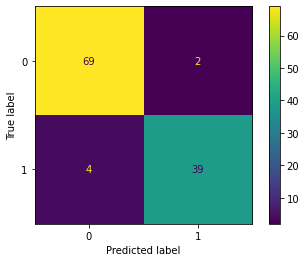

In [42]:
# split X and y from new_input_features before feeding to ANN
new_X_test = genetic_algorithm_new_input_testing_features_diagnosis_original.drop(['ground_truth'],axis=1)
new_y_test = genetic_algorithm_new_input_testing_features_diagnosis_original['ground_truth']

# predict new X test using pre-trained ANN before
predicted_test_original = genetic_algorithm_ann_model_diagnosis_original.predict(new_X_test)

# print testing results
print_model_experiment_results('Hasil Pengujian Data Testing Diagnosis Breast Cancer (Original) + Genetic Algorithm ', new_y_test, predicted_test_original)

### Ensemble stacking ML - ANN (without GA)

#### Create New Input Features from stacking ensemble ML before ANN process for preparing testing data new input features

In [43]:
new_input_testing_features_diagnosis_original = create_new_input_features(
    ensemble_classifiers_diagnosis_original, 
    diagnosis_X_test_original,
    diagnosis_y_test_original
)

#### Feed new testing input features into ANN pre-trained model

		HASIl UJI COBA HASIL PENGUJIAN DATA TESTING DIAGNOSIS BREAST CANCER (ORIGINAL)
	Akurasi Score:  0.9473684210526315
	Macro Recall Score:  0.9394038650507697
	Macro Precision Score:  0.9482124958235884
	Macro F1-score Score:  0.9434523809523809
	Macro F2-score Score:  0.9409397561841638
	Macro F0.5-score Score:  0.9462211043238712


              precision    recall  f1-score   support

           0       0.95      0.97      0.96        71
           1       0.95      0.91      0.93        43

    accuracy                           0.95       114
   macro avg       0.95      0.94      0.94       114
weighted avg       0.95      0.95      0.95       114



<Figure size 1008x576 with 0 Axes>

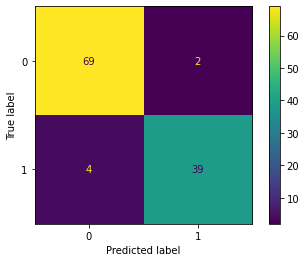

In [44]:
# split X and y from new_input_features before feeding to ANN
new_X_test = new_input_testing_features_diagnosis_original.drop(['ground_truth'],axis=1)
new_y_test = new_input_testing_features_diagnosis_original['ground_truth']

# predict new X test using pre-trained ANN before
predicted_test_original = ann_model_diagnosis_original.predict(new_X_test)

# print testing results
print_model_experiment_results('Hasil Pengujian Data Testing Diagnosis Breast Cancer (Original)', new_y_test, predicted_test_original)

## With Data Sampling Method (Upsampling)

### GA combine Ensemble stacking ML - ANN

#### Create New Input Features from stacking ensemble ML before ANN process for preparing testing data new input features

In [45]:
genetic_algorithm_new_input_testing_features_diagnosis_upsampling = create_new_input_features(
    genetic_algorithm_ensemble_classifiers_diagnosis_upsampling, 
    diagnosis_X_test_original,
    diagnosis_y_test_original
)

#### Feed new testing input features into ANN pre-trained model

		HASIl UJI COBA HASIL PENGUJIAN DATA TESTING DIAGNOSIS BREAST CANCER (UPSAMPLING) + GENETIC ALGORITHM
	Akurasi Score:  0.9649122807017544
	Macro Recall Score:  0.9672453324598755
	Macro Precision Score:  0.9594202898550726
	Macro F1-score Score:  0.962987012987013
	Macro F2-score Score:  0.9654573700082244
	Macro F0.5-score Score:  0.9607655626058076


              precision    recall  f1-score   support

           0       0.99      0.96      0.97        71
           1       0.93      0.98      0.95        43

    accuracy                           0.96       114
   macro avg       0.96      0.97      0.96       114
weighted avg       0.97      0.96      0.97       114



<Figure size 1008x576 with 0 Axes>

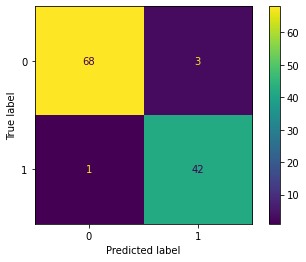

In [46]:
# split X and y from new_input_features before feeding to ANN
new_X_test = genetic_algorithm_new_input_testing_features_diagnosis_upsampling.drop(['ground_truth'],axis=1)
new_y_test = genetic_algorithm_new_input_testing_features_diagnosis_upsampling['ground_truth']

# predict new X test using pre-trained ANN before
predicted_test_upsampling = genetic_algorithm_ann_model_diagnosis_upsampling.predict(new_X_test)

# print testing results
print_model_experiment_results('Hasil Pengujian Data Testing Diagnosis Breast Cancer (Upsampling) + Genetic Algorithm', new_y_test, predicted_test_upsampling)

### Ensemble stacking ML - ANN (without GA)

#### Create New Input Features from stacking ensemble ML before ANN process for preparing testing data new input features

In [47]:
new_input_testing_features_diagnosis_upsampling = create_new_input_features(
    ensemble_classifiers_diagnosis_upsampling, 
    diagnosis_X_test_original,
    diagnosis_y_test_original
)

#### Feed new testing input features into ANN pre-trained model

		HASIl UJI COBA HASIL PENGUJIAN DATA TESTING DIAGNOSIS BREAST CANCER (UPSAMPLING)
	Akurasi Score:  0.9298245614035088
	Macro Recall Score:  0.9299050114641336
	Macro Precision Score:  0.9227053140096618
	Macro F1-score Score:  0.925974025974026
	Macro F2-score Score:  0.9282515894048382
	Macro F0.5-score Score:  0.9239348160401133


              precision    recall  f1-score   support

           0       0.96      0.93      0.94        71
           1       0.89      0.93      0.91        43

    accuracy                           0.93       114
   macro avg       0.92      0.93      0.93       114
weighted avg       0.93      0.93      0.93       114



<Figure size 1008x576 with 0 Axes>

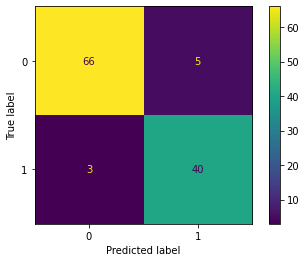

In [48]:
# split X and y from new_input_features before feeding to ANN
new_X_test = new_input_testing_features_diagnosis_upsampling.drop(['ground_truth'],axis=1)
new_y_test = new_input_testing_features_diagnosis_upsampling['ground_truth']

# predict new X test using pre-trained ANN before
predicted_test_upsampling = ann_model_diagnosis_upsampling.predict(new_X_test)

# print testing results
print_model_experiment_results('Hasil Pengujian Data Testing Diagnosis Breast Cancer (Upsampling)', new_y_test, predicted_test_upsampling)

## With Data Sampling Method (Downsampling)

### GA combine Ensemble stacking ML - ANN

#### Create New Input Features from stacking ensemble ML before ANN process for preparing testing data new input features

In [49]:
genetic_algorithm_new_input_testing_features_diagnosis_downsampling = create_new_input_features(
    genetic_algorithm_ensemble_classifiers_diagnosis_downsampling, 
    diagnosis_X_test_original,
    diagnosis_y_test_original
)

#### Feed new testing input features into ANN pre-trained model

		HASIl UJI COBA HASIL PENGUJIAN DATA TESTING DIAGNOSIS BREAST CANCER (DOWNSAMPLING) + GENETIC ALGORITHM
	Akurasi Score:  0.956140350877193
	Macro Recall Score:  0.9510317720275139
	Macro Precision Score:  0.9553571428571428
	Macro F1-score Score:  0.9531057178116
	Macro F2-score Score:  0.9518402814239212
	Macro F0.5-score Score:  0.9544350420467598


              precision    recall  f1-score   support

           0       0.96      0.97      0.97        71
           1       0.95      0.93      0.94        43

    accuracy                           0.96       114
   macro avg       0.96      0.95      0.95       114
weighted avg       0.96      0.96      0.96       114



<Figure size 1008x576 with 0 Axes>

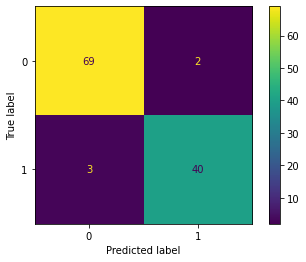

In [50]:
# split X and y from new_input_features before feeding to ANN
new_X_test = genetic_algorithm_new_input_testing_features_diagnosis_downsampling.drop(['ground_truth'],axis=1)
new_y_test = genetic_algorithm_new_input_testing_features_diagnosis_downsampling['ground_truth']

# predict new X test using pre-trained ANN before
predicted_test_downsampling = genetic_algorithm_ann_model_diagnosis_downsampling.predict(new_X_test)

# print testing results
print_model_experiment_results('Hasil Pengujian Data Testing Diagnosis Breast Cancer (Downsampling) + Genetic Algorithm', new_y_test, predicted_test_downsampling)

### Ensemble stacking ML - ANN (without GA)

#### Create New Input Features from stacking ensemble ML before ANN process for preparing testing data new input features

In [51]:
new_input_testing_features_diagnosis_downsampling = create_new_input_features(
    ensemble_classifiers_diagnosis_downsampling, 
    diagnosis_X_test_original,
    diagnosis_y_test_original
)

#### Feed new testing input features into ANN pre-trained model

		HASIl UJI COBA HASIL PENGUJIAN DATA TESTING DIAGNOSIS BREAST CANCER (DOWNSAMPLING)
	Akurasi Score:  0.956140350877193
	Macro Recall Score:  0.9602030789387488
	Macro Precision Score:  0.9491687979539642
	Macro F1-score Score:  0.9539245008487591
	Macro F2-score Score:  0.9575036488740616
	Macro F0.5-score Score:  0.9508932584991203


              precision    recall  f1-score   support

           0       0.99      0.94      0.96        71
           1       0.91      0.98      0.94        43

    accuracy                           0.96       114
   macro avg       0.95      0.96      0.95       114
weighted avg       0.96      0.96      0.96       114



<Figure size 1008x576 with 0 Axes>

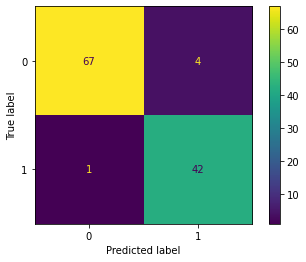

In [52]:
# split X and y from new_input_features before feeding to ANN
new_X_test = new_input_testing_features_diagnosis_downsampling.drop(['ground_truth'],axis=1)
new_y_test = new_input_testing_features_diagnosis_downsampling['ground_truth']

# predict new X test using pre-trained ANN before
predicted_test_downsampling = ann_model_diagnosis_downsampling.predict(new_X_test)

# print testing results
print_model_experiment_results('Hasil Pengujian Data Testing Diagnosis Breast Cancer (Downsampling)', new_y_test, predicted_test_downsampling)